In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from ast import literal_eval
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
import time
import shap
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.dummy import DummyRegressor
from sklearn import metrics, neighbors, linear_model
from sklearn.model_selection import cross_val_score
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
sns.set_theme(style="whitegrid")

In [3]:
def plot_feature_importance(importance,names,model_type):
    

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [4]:
data_test=pd.read_csv('data_test.csv')
data_train=pd.read_csv('data_train.csv')

In [5]:
X_test=data_test.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions'])
X_train=data_train.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions'])
y1_test=data_test[['SiteEnergyUse(kBtu)']]
y2_test=data_test[['TotalGHGEmissions']]
y1_train=data_train[['SiteEnergyUse(kBtu)']]
y2_train=data_train[['TotalGHGEmissions']]

In [6]:
X_train_log=X_train
X_test_log=X_test
logg=['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFABuilding(s)']
for i in logg:
    X_train_log[i]=np.log1p(X_train[i])
    X_test_log[i]=np.log1p(X_test[i])
X_test=data_test.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions'])
X_train=data_train.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions'])


In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std=scaler.transform(X_train)
X_test_std=scaler.transform(X_test)
scaler.fit(X_train_log)
X_train_std_log=scaler.transform(X_train_log)
X_test_std_log=scaler.transform(X_test_log)

preparation des variables l'une en Log et l'autre des variables standardisé

In [8]:
score_time=dict()
fit_time=dict()
RMSE_test=dict()
Score_test=dict()
Score_train=dict()


Trouver le meilleur regressor pour l'energie utilisé

In [9]:
dummy_regr = DummyRegressor(strategy="mean")
scores= cross_val_score(dummy_regr,X_train, y1_train, cv=5)
st = time.time() #starting time
dummy_regr.fit(X_train,y1_train)

mt = time.time()
A=dummy_regr.score(X_test, y1_test)

et = time.time()
print(A)

#print(np.mean((dummy_regr_ene.predict(X_test) - y1_test) ** 2))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, dummy_regr.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['dummy regr']=mt-st
score_time['dummy regr']=et-mt
Score_test['dummy regr']=dummy_regr.score(X_test, y1_test)
RMSE_test['dummy regr']=np.sqrt(metrics.mean_squared_error(y1_test, dummy_regr.predict(X_test)))
Score_train['dummy regr']=scores.mean()

-0.0014050745120262054
RMSE : 19315248.79
train score : -0.0046


In [10]:

lr = linear_model.LinearRegression()
scores= cross_val_score(lr,X_train, y1_train, cv=5)
st = time.time()

lr.fit(X_train,y1_train)

mt= time.time()

print(lr.score(X_test, y1_test))
et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, lr.predict(X_test)))))
#print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, lr_GHG.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))

fit_time['linear regr']=mt-st
score_time['linear regr']=et-mt
Score_test['linear regr']=lr.score(X_test, y1_test)
RMSE_test['linear regr']=np.sqrt(metrics.mean_squared_error(y1_test, lr.predict(X_test)))
Score_train['linear regr']=scores.mean()

0.5008713133904665
RMSE : 13636461.10
train score : 0.5431


In [11]:
lr_log = linear_model.LinearRegression()
scores= cross_val_score(lr_log,X_train_log, y1_train, cv=5)
st = time.time()
lr_log.fit(X_train_log,y1_train)

mt= time.time()

print(lr_log.score(X_test_log, y1_test))

et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, lr_log.predict(X_test_log)))))
print("train score : {:.4f}".format(scores.mean()))


fit_time['linear regr log']=mt-st
score_time['linear regr log']=et-mt
Score_test['linear regr log']=lr_log.score(X_test, y1_test)
RMSE_test['linear regr log']=np.sqrt(metrics.mean_squared_error(y1_test, lr_log.predict(X_test)))
Score_train['linear regr log']=scores.mean()

0.2384313046795119
RMSE : 16844183.13
train score : 0.2990


In [12]:
tt = TransformedTargetRegressor(regressor=linear_model.LinearRegression(),
                                func=np.log1p, inverse_func=np.expm1)
scores= cross_val_score(tt,X_train, y1_train, cv=5)
st=time.time()
tt.fit(X_train,y1_train)

mt=time.time()
print(tt.score(X_test, y1_test))

et=time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['TransTarget regr']=mt-st
score_time['TransTarget regr']=et-mt
Score_test['TransTarget regr']=tt.score(X_test, y1_test)
RMSE_test['TransTarget regr']=np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test)))
Score_train['TransTarget regr']=scores.mean()

-8.031483475137717
RMSE : 58006272.49
train score : -42368564173643512492851200.0000


In [13]:
tt = TransformedTargetRegressor(regressor=linear_model.LinearRegression(),
                                func=np.log1p, inverse_func=np.expm1)
scores= cross_val_score(tt,X_train_log, y1_train, cv=5)
st=time.time()
tt.fit(X_train_log,y1_train)

mt=time.time()
print(tt.score(X_test_log, y1_test))
et=time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test_log)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['TransTarget regr log']=mt-st
score_time['TransTarget regr log']=et-mt
Score_test['TransTarget regr log']=tt.score(X_test_log, y1_test)
RMSE_test['TransTarget regr log']=np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test_log)))
Score_train['TransTarget regr log']=scores.mean()

0.45048566325920036
RMSE : 14308197.51
train score : 0.5580


In [14]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
scores= cross_val_score(knn,X_train_std, y1_train, cv=5)
st=time.time()
knn.fit(X_train_std,y1_train)
mt=time.time()
print(knn.score(X_test_std, y1_test))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, knn.predict(X_test_std)))))
print("train score : {:.4f}".format(scores.mean()))
et=time.time()

#fit_time['knn regr']=mt-st
#score_time['knn regr']=et-mt
#Score['knn regr']=knn.score(X_test_std, y1_test)
#RMSE['knn regr']=np.sqrt(metrics.mean_squared_error(y1_test, knn.predict(X_test_std)))

0.6306042563488787
RMSE : 11731170.75
train score : 0.4888


In [15]:
param_grid = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
scor = 'r2'


knn = GridSearchCV(neighbors.KNeighborsRegressor(), 
                   param_grid,     # hyperparamètres à tester
                   cv=5,           # nombre de folds de validation croisée
                   scoring=scor   # score à optimiser
                   )
st=time.time()
knn.fit(X_train_std,y1_train)
mt=time.time()
print(metrics.r2_score(y1_test, knn.predict(X_test_std)))

et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, knn.predict(X_test_std)))))
fit_time['knn regr']=mt-st
score_time['knn regr']=et-mt
Score_test['knn regr']=metrics.r2_score(y1_test, knn.predict(X_test_std))
RMSE_test['knn regr']=np.sqrt(metrics.mean_squared_error(y1_test, knn.predict(X_test_std)))

0.6306042563488787
RMSE : 11731170.75


In [16]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(knn.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        knn.cv_results_['mean_test_score'], # score moyen
        knn.cv_results_['std_test_score'],  # écart-type du score
        knn.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        scor,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 3}
Résultats de la validation croisée :
r2 = 0.485 (+/-0.283) for {'n_neighbors': 2}
r2 = 0.489 (+/-0.198) for {'n_neighbors': 3}
r2 = 0.455 (+/-0.207) for {'n_neighbors': 4}
r2 = 0.442 (+/-0.212) for {'n_neighbors': 5}
r2 = 0.425 (+/-0.214) for {'n_neighbors': 6}
r2 = 0.421 (+/-0.199) for {'n_neighbors': 7}
r2 = 0.434 (+/-0.233) for {'n_neighbors': 8}
r2 = 0.428 (+/-0.240) for {'n_neighbors': 9}
r2 = 0.411 (+/-0.212) for {'n_neighbors': 10}


In [17]:
Score_train['knn regr']=max(knn.cv_results_['mean_test_score'])

In [18]:
base=0
for i in range(2,10,1):
    tt=TransformedTargetRegressor(regressor=neighbors.KNeighborsRegressor(n_neighbors=i),
                                func=np.log1p, inverse_func=np.expm1)
    scores= cross_val_score(tt,X_train_std_log,y1_train, cv=5)
    mean=scores.mean()
    print(scores.mean())
    if base<mean:
        base=mean
        
        result=[i,mean]
result

0.3819534038268954
0.38374958560556244
0.37086987391917503
0.3544927121534333
0.33018809737966787
0.32577788827963705
0.3106348747682769
0.2912786229810401


[3, 0.38374958560556244]

In [19]:
tt=TransformedTargetRegressor(regressor=neighbors.KNeighborsRegressor(n_neighbors=result[0]),
                                func=np.log1p, inverse_func=np.expm1)


st=time.time()
tt.fit(X_train_std_log,y1_train)
mt=time.time()
r2=metrics.r2_score(y1_test, tt.predict(X_test_std_log))
et = time.time()
rmse=np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test_std_log)))

print(r2)
print("RMSE : {:.2f}".format(rmse))
print("train score : {:.4f}".format(result[1]))
    
fit_time['knn regr log']=mt-st
score_time['knn regr log']=et-mt
Score_test['knn regr log']=metrics.r2_score(y1_test, tt.predict(X_test_std_log))
RMSE_test['knn regr log']=np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test_std_log)))
Score_train['knn regr log']=result[1]

0.2708696259083122
RMSE : 16481548.31
train score : 0.3837


la regression de ridge

In [20]:
y1_train_log=np.log1p(y1_train)
n_alphas = 200
alphas = np.logspace(0, 3, n_alphas)
#alphas = [1,0]
ridge = linear_model.Ridge()
coefs = []
errors = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_log, y1_train_log)
    coefs.append(ridge.coef_[0])
    y1_pred=np.expm1(ridge.predict(X_test_log))
    errors.append([np.sqrt(metrics.mean_squared_error(y1_test, y1_pred))])
#errors

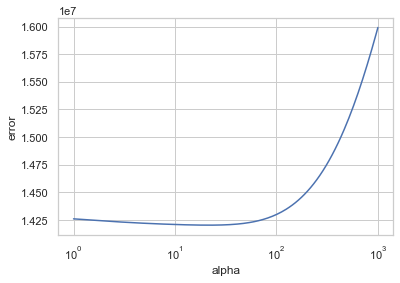

In [21]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

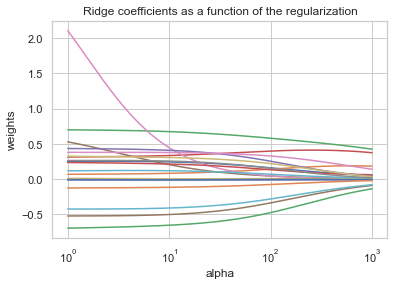

In [22]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [23]:
base=0
for a in alphas:
    tt=TransformedTargetRegressor(regressor=linear_model.Ridge(alpha=a),
                                func=np.log1p, inverse_func=np.expm1)
    scores= cross_val_score(tt,X_train_log,y1_train, cv=5)
    mean=scores.mean()
    #print(scores.mean())
    if base<mean:
        base=mean
        
        result=[a,mean]
result

[32.176417502507356, 0.603432882261329]

In [24]:
tt=TransformedTargetRegressor(regressor=linear_model.Ridge(alpha=result[0]),
                              func=np.log1p, inverse_func=np.expm1)
st=time.time()
tt.fit(X_train_log,y1_train)
mt=time.time()
print(metrics.r2_score(y1_test, tt.predict(X_test_log)))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test_log)))))
et = time.time()
print("train score : {:.4f}".format(result[1]))
fit_time['ridge log']=mt-st
score_time['ridge log']=et-mt
Score_test['ridge log']=metrics.r2_score(y1_test, tt.predict(X_test_log))
RMSE_test['ridge log']=np.sqrt(metrics.mean_squared_error(y1_test, tt.predict(X_test_log)))
Score_train['ridge log']=result[1]


0.45832068460085296
RMSE : 14205827.56
train score : 0.6034


random forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 14, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 5, 8, 11, 14, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_ene = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_ene_random = RandomizedSearchCV(estimator = rf_ene, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_ene_random.fit(X_train, y1_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaco

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaco

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaco

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 8, 11, 14, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [28]:
rf_ene_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': False}

In [29]:

rf = RandomForestRegressor(n_estimators = 1800,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features ='sqrt',
                           max_depth = 8,
                           bootstrap = False)
scores=cross_val_score(rf,X_train,y1_train, cv=5)
st=time.time()
rf.fit(X_train,y1_train)
mt=time.time()
print(metrics.r2_score(y1_test, rf.predict(X_test)))

et = time.time()

print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, rf.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['random forest']=mt-st
score_time['random forest']=et-mt
Score_test['random forest']=metrics.r2_score(y1_test, rf.predict(X_test))
RMSE_test['random forest']=np.sqrt(metrics.mean_squared_error(y1_test, rf.predict(X_test)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7852095360067752
RMSE : 8945464.79
train score : 0.5845


In [30]:
Score_train['random forest']=scores.mean()

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)

In [32]:
pprint(reg.get_params())

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [33]:
search_grid={'n_estimators':[500,1000,2000],
             'learning_rate':[.001,0.01,.1],
             'max_depth':[1,2,4],
             'subsample':[.5,.75,1],
             'random_state':[1]}
random_reg=RandomizedSearchCV(estimator = reg, param_distributions = search_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)

In [34]:
random_reg.fit(X_train,y1_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversio

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversio

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversio

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [1, 2, 4],
                                        'n_estimators': [500, 1000, 2000],
                                        'random_state': [1],
                                        'subsample': [0.5, 0.75, 1]},
                   verbose=2)

In [35]:
random_reg.best_params_

{'subsample': 1,
 'random_state': 1,
 'n_estimators': 1000,
 'max_depth': 4,
 'learning_rate': 0.1}

In [36]:
reg=GradientBoostingRegressor(subsample= 1,
                              random_state= 1,
                              n_estimators= 500,
                              max_depth= 4,
                              learning_rate= 0.01)
scores=cross_val_score(reg,X_train,y1_train, cv=5)
st=time.time()
reg.fit(X_train,y1_train)
mt=time.time()
print(metrics.r2_score(y1_test, reg.predict(X_test)))

et = time.time()

print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test, reg.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['gradiant boost']=mt-st
score_time['gradiant boost']=et-mt
Score_test['gradiant boost']=metrics.r2_score(y1_test, reg.predict(X_test))
RMSE_test['gradiant boost']=np.sqrt(metrics.mean_squared_error(y1_test, reg.predict(X_test)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.5468614389801321
RMSE : 12993044.42
train score : 0.5489


In [37]:
Score_train['gradiant boost']=scores.mean()

In [38]:
ress={'RMSE test' : RMSE_test,
      'Score test' : Score_test,
      'Score train' : Score_train,
      'fit time' : fit_time,
      'score time' :score_time}
resultat_energie = pd.DataFrame.from_dict(ress)


le meilleur regresseur pour l'energie est le random forest

recherche de la regression pour les Gas a effet de serre

In [39]:
ress={'RMSE test' : RMSE_test,
      'Score test' : Score_test,
      'Score train' : Score_train,
      'fit time' : fit_time,
      'score time' :score_time}
resultat_energie = pd.DataFrame.from_dict(ress)


In [40]:
score_time=dict()
fit_time=dict()
RMSE_test=dict()
Score_test=dict()
Score_train=dict()

In [41]:
dummy_regr = DummyRegressor(strategy="mean")
scores= cross_val_score(dummy_regr,X_train, y2_train, cv=5)
st = time.time() #starting time
dummy_regr.fit(X_train,y2_train)

mt = time.time()
A=dummy_regr.score(X_test, y2_test)

et = time.time()
print(A)

print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, dummy_regr.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['dummy regr']=mt-st
score_time['dummy regr']=et-mt
Score_test['dummy regr']=dummy_regr.score(X_test, y2_test)
RMSE_test['dummy regr']=np.sqrt(metrics.mean_squared_error(y2_test, dummy_regr.predict(X_test)))
Score_train['dummy regr']=scores.mean()

-0.0018569523498352947
RMSE : 552.62
train score : -0.0043


In [42]:

lr = linear_model.LinearRegression()
scores= cross_val_score(lr,X_train, y2_train, cv=5)
st = time.time()

lr.fit(X_train,y2_train)

mt= time.time()

print(lr.score(X_test, y2_test))
et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, lr.predict(X_test)))))
#print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, lr_GHG.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))

fit_time['linear regr']=mt-st
score_time['linear regr']=et-mt
Score_test['linear regr']=lr.score(X_test, y2_test)
RMSE_test['linear regr']=np.sqrt(metrics.mean_squared_error(y2_test, lr.predict(X_test)))
Score_train['linear regr']=scores.mean()

0.40921307902520243
RMSE : 424.36
train score : 0.0561


In [43]:
scores

array([ 0.26350263, -0.75233481,  0.27299558,  0.29606119,  0.20003624])

pour la deuxieme validation on a eu un score négatif

In [44]:
lr_log = linear_model.LinearRegression()
scores= cross_val_score(lr_log,X_train_log, y2_train, cv=5)
st = time.time()
lr_log.fit(X_train_log,y2_train)

mt= time.time()

print(lr_log.score(X_test_log, y2_test))

et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, lr_log.predict(X_test_log)))))
print("train score : {:.4f}".format(scores.mean()))


fit_time['linear regr log']=mt-st
score_time['linear regr log']=et-mt
Score_test['linear regr log']=lr_log.score(X_test, y2_test)
RMSE_test['linear regr log']=np.sqrt(metrics.mean_squared_error(y2_test, lr_log.predict(X_test)))
Score_train['linear regr log']=scores.mean()

0.1652950644131248
RMSE : 504.42
train score : 0.2837


In [45]:
scores

array([0.28777768, 0.48686528, 0.17998456, 0.24681664, 0.21725399])

In [46]:
tt = TransformedTargetRegressor(regressor=linear_model.LinearRegression(),
                                func=np.log1p, inverse_func=np.expm1)
scores= cross_val_score(tt,X_train, y2_train, cv=5)
st=time.time()
tt.fit(X_train,y2_train)

mt=time.time()
print(tt.score(X_test, y2_test))

et=time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['TransTarget regr']=mt-st
score_time['TransTarget regr']=et-mt
Score_test['TransTarget regr']=tt.score(X_test, y2_test)
RMSE_test['TransTarget regr']=np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test)))
Score_train['TransTarget regr']=scores.mean()

-0.18251954404109139
RMSE : 600.38
train score : -1007875427684267092439203840.0000


In [47]:
tt = TransformedTargetRegressor(regressor=linear_model.LinearRegression(),
                                func=np.log1p, inverse_func=np.expm1)
scores= cross_val_score(tt,X_train_log, y2_train, cv=5)
st=time.time()
tt.fit(X_train_log,y2_train)

mt=time.time()
print(tt.score(X_test_log, y2_test))
et=time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test_log)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['TransTarget regr log']=mt-st
score_time['TransTarget regr log']=et-mt
Score_test['TransTarget regr log']=tt.score(X_test_log, y2_test)
RMSE_test['TransTarget regr log']=np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test_log)))
Score_train['TransTarget regr log']=scores.mean()

0.3929073235983387
RMSE : 430.18
train score : -0.6561


In [48]:
scores

array([ 0.53527092, -4.89777372,  0.3909483 ,  0.44389041,  0.24708125])

In [49]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
scores= cross_val_score(knn,X_train_std, y2_train, cv=5)
st=time.time()
knn.fit(X_train_std,y2_train)
mt=time.time()
print(knn.score(X_test_std, y2_test))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, knn.predict(X_test_std)))))
print("train score : {:.4f}".format(scores.mean()))
et=time.time()

#fit_time['knn regr']=mt-st
#score_time['knn regr']=et-mt
#Score['knn regr']=knn.score(X_test_std, y1_test)
#RMSE['knn regr']=np.sqrt(metrics.mean_squared_error(y1_test, knn.predict(X_test_std)))

0.5928784882512518
RMSE : 352.28
train score : 0.4574


In [50]:
scores

array([0.61060603, 0.70377797, 0.23459939, 0.45218525, 0.28594996])

In [51]:
param_grid = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
scor = 'r2'


knn = GridSearchCV(neighbors.KNeighborsRegressor(), 
                   param_grid,     # hyperparamètres à tester
                   cv=5,           # nombre de folds de validation croisée
                   scoring=scor   # score à optimiser
                   )
st=time.time()
knn.fit(X_train_std,y2_train)
mt=time.time()
print(metrics.r2_score(y2_test, knn.predict(X_test_std)))

et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, knn.predict(X_test_std)))))
fit_time['knn regr']=mt-st
score_time['knn regr']=et-mt
Score_test['knn regr']=metrics.r2_score(y2_test, knn.predict(X_test_std))
RMSE_test['knn regr']=np.sqrt(metrics.mean_squared_error(y2_test, knn.predict(X_test_std)))

0.5928784882512518
RMSE : 352.28


In [52]:
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(knn.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        knn.cv_results_['mean_test_score'], # score moyen
        knn.cv_results_['std_test_score'],  # écart-type du score
        knn.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        scor,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 3}
Résultats de la validation croisée :
r2 = 0.354 (+/-0.576) for {'n_neighbors': 1}
r2 = 0.413 (+/-0.406) for {'n_neighbors': 2}
r2 = 0.457 (+/-0.361) for {'n_neighbors': 3}
r2 = 0.429 (+/-0.283) for {'n_neighbors': 4}
r2 = 0.403 (+/-0.214) for {'n_neighbors': 5}
r2 = 0.376 (+/-0.211) for {'n_neighbors': 6}
r2 = 0.374 (+/-0.209) for {'n_neighbors': 7}
r2 = 0.390 (+/-0.178) for {'n_neighbors': 8}
r2 = 0.379 (+/-0.179) for {'n_neighbors': 9}
r2 = 0.363 (+/-0.161) for {'n_neighbors': 10}


In [53]:
Score_train['knn regr']=max(knn.cv_results_['mean_test_score'])

In [54]:
base=0
for i in range(1,10,1):
    tt=TransformedTargetRegressor(regressor=neighbors.KNeighborsRegressor(n_neighbors=i),
                                func=np.log1p, inverse_func=np.expm1)
    scores= cross_val_score(tt,X_train_std_log,y2_train, cv=5)
    mean=scores.mean()
    print(scores.mean())
    if base<mean:
        base=mean
        
        result=[i,mean]
result

0.3596467781233686
0.3566975584971669
0.30980363219985846
0.28723136212110956
0.2777929389748076
0.2319116127021453
0.2308137801195437
0.21714871373254385
0.20702629367582048


[1, 0.3596467781233686]

In [55]:
tt=TransformedTargetRegressor(regressor=neighbors.KNeighborsRegressor(n_neighbors=result[0]),
                                func=np.log1p, inverse_func=np.expm1)


st=time.time()
tt.fit(X_train_std_log,y2_train)
mt=time.time()
r2=metrics.r2_score(y2_test, tt.predict(X_test_std_log))
et = time.time()
rmse=np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test_std_log)))

print(r2)
print("RMSE : {:.2f}".format(rmse))
print("train score : {:.4f}".format(result[1]))
    
fit_time['knn regr log']=mt-st
score_time['knn regr log']=et-mt
Score_test['knn regr log']=metrics.r2_score(y2_test, tt.predict(X_test_std_log))
RMSE_test['knn regr log']=np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test_std_log)))
Score_train['knn regr log']=result[1]

0.16339532244574462
RMSE : 504.99
train score : 0.3596


la regression de ridge

In [56]:
y2_train_log=np.log1p(y2_train)
n_alphas = 200
alphas = np.logspace(-3, 4, n_alphas)
#alphas = [1,0]
ridge = linear_model.Ridge()
coefs = []
errors = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_log, y2_train_log)
    coefs.append(ridge.coef_[0])
    y2_pred=np.expm1(ridge.predict(X_test_log))
    errors.append([np.sqrt(metrics.mean_squared_error(y2_test, y2_pred))])
#errors

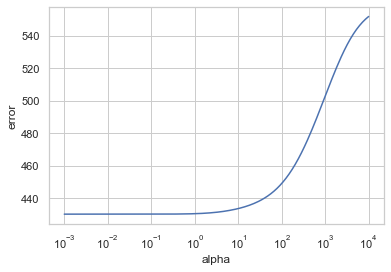

In [57]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

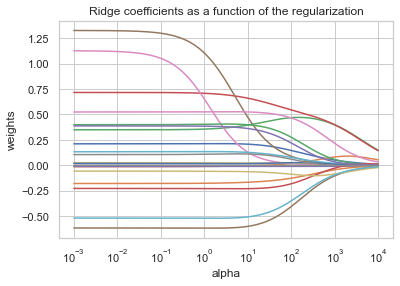

In [58]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [59]:
base=0
for a in alphas:
    tt=TransformedTargetRegressor(regressor=linear_model.Ridge(alpha=a),
                                func=np.log1p, inverse_func=np.expm1)
    scores= cross_val_score(tt,X_train_log,y2_train, cv=5)
    mean=scores.mean()
    #print(scores.mean())
    if base<mean:
        base=mean
        
        result=[a,mean]
result

[174.26333860096508, 0.37520871677121737]

In [60]:
tt=TransformedTargetRegressor(regressor=linear_model.Ridge(alpha=result[0]),
                              func=np.log1p, inverse_func=np.expm1)
st=time.time()
tt.fit(X_train_log,y2_train)
mt=time.time()
print(metrics.r2_score(y2_test, tt.predict(X_test_log)))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test_log)))))
et = time.time()
print("train score : {:.4f}".format(result[1]))
fit_time['ridge log']=mt-st
score_time['ridge log']=et-mt
Score_test['ridge log']=metrics.r2_score(y2_test, tt.predict(X_test_log))
RMSE_test['ridge log']=np.sqrt(metrics.mean_squared_error(y2_test, tt.predict(X_test_log)))
Score_train['ridge log']=result[1]


0.3126270015846283
RMSE : 457.74
train score : 0.3752


random forest

In [61]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 14, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 5, 8, 11, 14, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [62]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_ene = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_ene_random = RandomizedSearchCV(estimator = rf_ene, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_ene_random.fit(X_train, y2_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaco

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaco

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zekrifaabdelmoumen/anaco

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 8, 11, 14, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [63]:
rf_ene_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 14,
 'bootstrap': False}

In [64]:

rf = RandomForestRegressor(n_estimators = 200,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features ='sqrt',
                           max_depth = 14,
                           bootstrap = False)
scores=cross_val_score(rf,X_train,y2_train, cv=5)
st=time.time()
rf.fit(X_train,y2_train)
mt=time.time()
print(metrics.r2_score(y2_test, rf.predict(X_test)))

et = time.time()

print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, rf.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['random forest']=mt-st
score_time['random forest']=et-mt
Score_test['random forest']=metrics.r2_score(y2_test, rf.predict(X_test))
RMSE_test['random forest']=np.sqrt(metrics.mean_squared_error(y2_test, rf.predict(X_test)))
Score_train['random forest']=scores.mean()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7774874611245512
RMSE : 260.44
train score : 0.6037


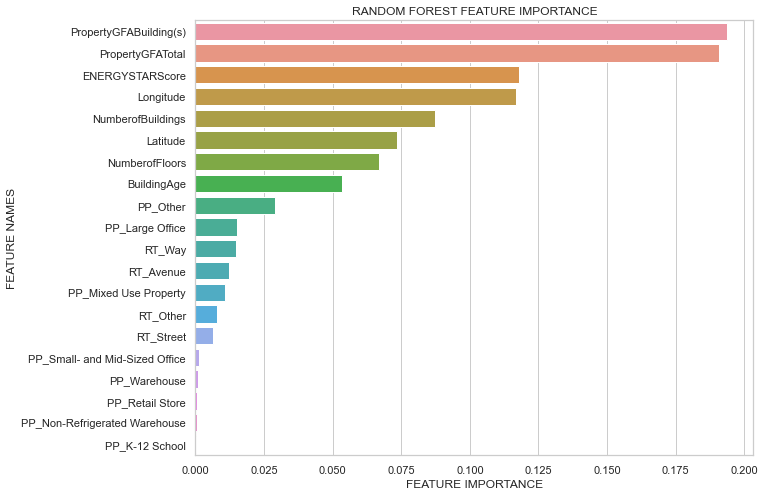

In [65]:
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST ')

In [66]:

reg = GradientBoostingRegressor(random_state=0)

In [67]:
search_grid={'n_estimators':[1600, 1800,2000],
             'learning_rate':[.001],
             'max_depth':[12,10],
             'subsample':[.5,1],
             'random_state':[1]}
random_reg=RandomizedSearchCV(estimator = reg, param_distributions = search_grid, n_iter = 12, cv = 3, verbose=2, n_jobs = -1)

In [68]:
random_reg.fit(X_train,y2_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversio

/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zekrifaabdelmoumen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversio

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001],
                                        'max_depth': [12, 10],
                                        'n_estimators': [1600, 1800, 2000],
                                        'random_state': [1],
                                        'subsample': [0.5, 1]},
                   verbose=2)

In [69]:
random_reg.best_params_

{'subsample': 0.5,
 'random_state': 1,
 'n_estimators': 2000,
 'max_depth': 12,
 'learning_rate': 0.001}

In [70]:
reg=GradientBoostingRegressor(subsample= 0.5,
                              random_state= 1,
                              n_estimators= 2000,
                              max_depth= 12,
                              learning_rate= 0.001)
scores=cross_val_score(reg,X_train,y2_train, cv=5)
st=time.time()
reg.fit(X_train,y2_train)
mt=time.time()
print(metrics.r2_score(y2_test, reg.predict(X_test)))

et = time.time()

print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, reg.predict(X_test)))))
print("train score : {:.4f}".format(scores.mean()))
fit_time['gradiant boost']=mt-st
score_time['gradiant boost']=et-mt
Score_test['gradiant boost']=metrics.r2_score(y2_test, reg.predict(X_test))
RMSE_test['gradiant boost']=np.sqrt(metrics.mean_squared_error(y2_test, reg.predict(X_test)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.13333188238694094
RMSE : 513.98
train score : 0.5546


In [71]:
Score_train['gradiant boost']=scores.mean()

In [72]:
ress={'RMSE test' : RMSE_test,
      'Score test' : Score_test,
      'Score train' : Score_train,
      'fit time' : fit_time,
      'score time' :score_time}
resultat_GHG = pd.DataFrame.from_dict(ress)
resultat_GHG

,RMSE test,Score test,Score train,fit time,score time
dummy regr,5.526182e+02,-1.856952e-03,-4.316541e-03,0.001885,0.001549
linear regr,4.243632e+02,4.092131e-01,5.605217e-02,0.003625,0.002385
linear regr log,6.083651e+07,-1.214182e+10,2.837396e-01,0.003201,0.004080
TransTarget regr,6.003804e+02,-1.825195e-01,-1.007875e+27,0.007792,0.004000
TransTarget regr log,4.301796e+02,3.929073e-01,-6.561166e-01,0.005568,0.005079
knn regr,3.522770e+02,5.928785e-01,4.574237e-01,1.130972,0.028371
knn regr log,5.049896e+02,1.633953e-01,3.596468e-01,0.003856,0.023504
ridge log,4.577397e+02,3.126270e-01,3.752087e-01,0.006689,0.008105
random forest,2.604351e+02,7.774875e-01,6.036597e-01,0.845524,0.033617
gradiant boost,5.139830e+02,1.333319e-01,5.545731e-01,15.688329,0.088926


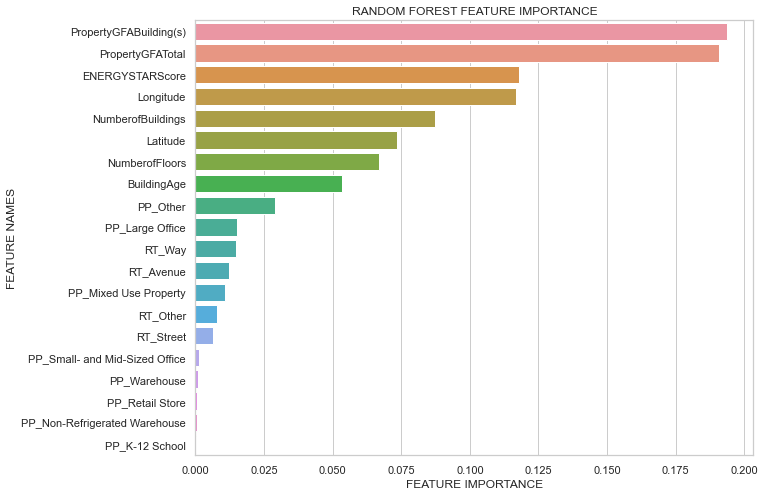

In [73]:
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST ')

l'impact de l'energie star score sur les regressor

In [74]:
X_train_1 = X_train.drop(columns='ENERGYSTARScore')
X_test_1 = X_test.drop(columns='ENERGYSTARScore')

In [75]:
rf = RandomForestRegressor(n_estimators = 200,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features ='sqrt',
                           max_depth = 14,
                           bootstrap = False)
#scores=cross_val_score(rf,X_train_1,y2_train, cv=5)
st=time.time()
rf.fit(X_train_1,y2_train)
mt=time.time()
print(metrics.r2_score(y2_test, rf.predict(X_test_1)))

et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, rf.predict(X_test_1)))))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.897513936487114
RMSE : 176.75


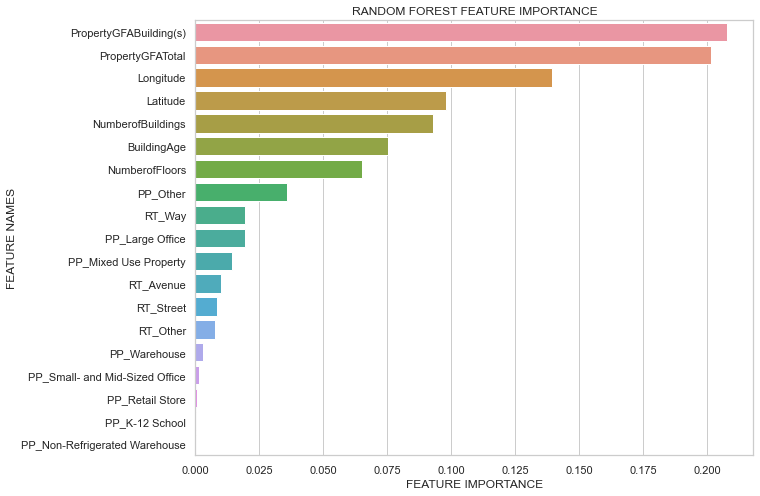

In [76]:
plot_feature_importance(rf.feature_importances_,X_train_1.columns,'RANDOM FOREST ')

In [77]:
resultat_energie

,RMSE test,Score test,Score train,fit time,score time
dummy regr,1.931525e+07,-1.405075e-03,-4.591059e-03,0.001056,0.001183
linear regr,1.363646e+07,5.008713e-01,5.431323e-01,0.004933,0.002887
linear regr log,2.574669e+12,-1.779312e+10,2.990389e-01,0.002916,0.002643
TransTarget regr,5.800627e+07,-8.031483e+00,-4.236856e+25,0.004568,0.003527
TransTarget regr log,1.430820e+07,4.504857e-01,5.579581e-01,0.003580,0.003382
knn regr,1.173117e+07,6.306043e-01,4.887791e-01,0.797941,0.020990
knn regr log,1.648155e+07,2.708696e-01,3.837496e-01,0.003538,0.032710
ridge log,1.420583e+07,4.583207e-01,6.034329e-01,0.005537,0.006331
random forest,8.945465e+06,7.852095e-01,5.844618e-01,4.992639,0.186700
gradiant boost,1.299304e+07,5.468614e-01,5.489221e-01,2.678044,0.006805


In [78]:
resultat_GHG

,RMSE test,Score test,Score train,fit time,score time
dummy regr,5.526182e+02,-1.856952e-03,-4.316541e-03,0.001885,0.001549
linear regr,4.243632e+02,4.092131e-01,5.605217e-02,0.003625,0.002385
linear regr log,6.083651e+07,-1.214182e+10,2.837396e-01,0.003201,0.004080
TransTarget regr,6.003804e+02,-1.825195e-01,-1.007875e+27,0.007792,0.004000
TransTarget regr log,4.301796e+02,3.929073e-01,-6.561166e-01,0.005568,0.005079
knn regr,3.522770e+02,5.928785e-01,4.574237e-01,1.130972,0.028371
knn regr log,5.049896e+02,1.633953e-01,3.596468e-01,0.003856,0.023504
ridge log,4.577397e+02,3.126270e-01,3.752087e-01,0.006689,0.008105
random forest,2.604351e+02,7.774875e-01,6.036597e-01,0.845524,0.033617
gradiant boost,5.139830e+02,1.333319e-01,5.545731e-01,15.688329,0.088926


In [79]:
rf = RandomForestRegressor(n_estimators = 200,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features ='sqrt',
                           max_depth = 14,
                           bootstrap = False)
#scores=cross_val_score(rf,X_train_1,y2_train, cv=5)
st=time.time()
rf.fit(X_train_log,y2_train)
mt=time.time()
print(metrics.r2_score(y2_test, rf.predict(X_test_log)))

et = time.time()
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, rf.predict(X_test_log)))))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7833470290050544
RMSE : 256.98
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   6.3s
[CV] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   6.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  11.1s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.1s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  13.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   5.2s
[CV] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   4.7s
[CV] E

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   6.4s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  11.1s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  11.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   9.5s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   5.0s
[CV] END bootstrap=True, max_depth=14,

[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=   5.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  12.3s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   6.3s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   9.5s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   6.0s
[CV] END bootstrap=True, max_depth

In [1]:
#print(shap.__version__)
rf.fit(X_train, y2_train.values.ravel())
X_shap=shap.sample(X_train, 100)
explainer = shap.TreeExplainer(rf)
rf_shap_values=explainer.shap_values(X_shap)


NameError: name 'rf' is not defined

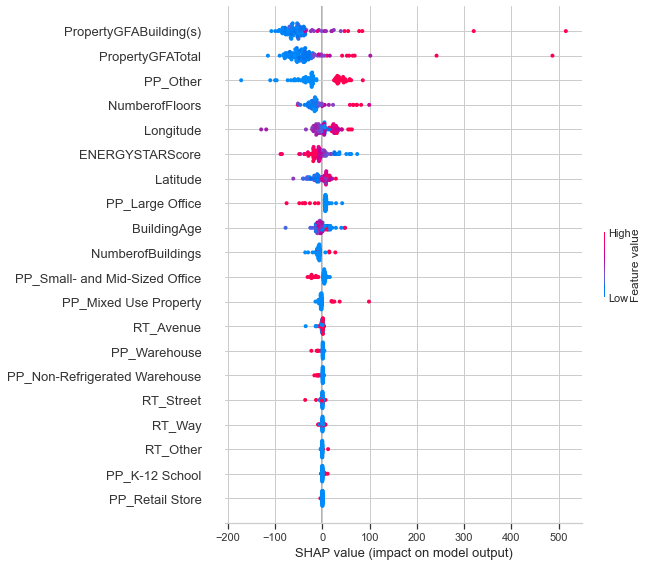

In [87]:
shap.summary_plot(rf_shap_values, X_shap)

In [81]:
X_shap

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,Latitude,Longitude,BuildingAge,RT_Avenue,RT_Other,RT_Street,RT_Way,PP_K-12 School,PP_Large Office,PP_Mixed Use Property,PP_Non-Refrigerated Warehouse,PP_Other,PP_Retail Store,PP_Small- and Mid-Sized Office,PP_Warehouse
2607,0.693147,1.386294,10.495183,10.495183,62.50,47.540791,-122.323221,53.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1653,0.693147,0.693147,10.170303,10.170303,43.00,47.723370,-122.343730,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
835,0.693147,1.386294,12.027550,12.027550,60.50,47.608951,-122.342138,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
763,0.693147,1.098612,11.115800,11.115800,65.00,47.614906,-122.330401,85.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1731,0.693147,1.098612,10.748067,10.748067,73.00,47.644100,-122.347950,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1033,0.693147,3.218876,11.692761,11.692761,62.00,47.617097,-122.351777,33.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
277,0.693147,0.693147,9.928229,9.928229,65.00,47.551270,-122.325760,47.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1778,0.693147,2.079442,11.172560,11.172560,99.00,47.609891,-122.341425,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1828,0.693147,1.386294,10.547339,10.547339,89.50,47.586003,-122.303528,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2362,0.693147,1.791759,11.713832,11.713832,93.00,47.699170,-122.326800,33.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


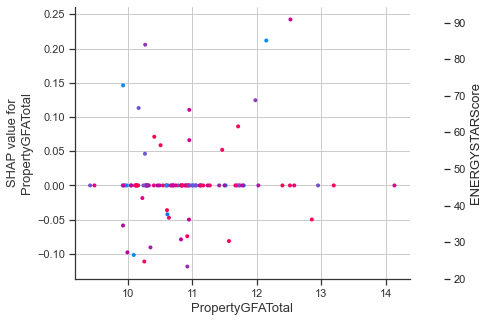

In [95]:
shap.dependence_plot("PropertyGFATotal", rf_shap_values, X_shap)

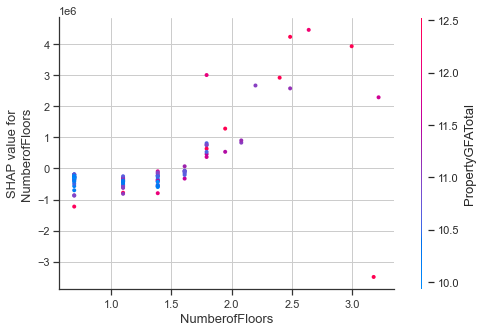

In [83]:
shap.dependence_plot("NumberofFloors", rf_shap_values, X_shap)

<AxesSubplot:xlabel='NumberofBuildings', ylabel='SiteEnergyUse(kBtu)'>

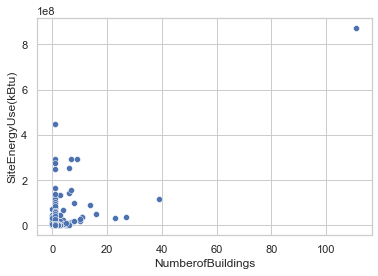

In [84]:
sns.scatterplot(data=data_train, x="NumberofBuildings", y="SiteEnergyUse(kBtu)")